# ЛР 6 — Сегментация изображений

*Зубарева Марина, РИМ-181226*

In [1]:
import numpy as np
from skimage import data
from skimage import segmentation as seg
from skimage import filters as filters
from skimage import draw as draw
from skimage import color as color
from skimage.io import imshow, imread
from skimage.feature import canny
from skimage.transform import resize
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.filters import sobel
from skimage.morphology import watershed
from skimage.color import label2rgb
import cv2

Text(0.5,1,'Гистограмма значений серого')

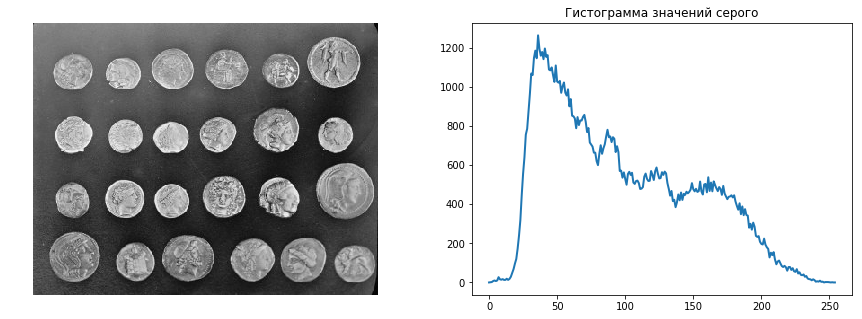

In [2]:
img_coins = data.coins()
hist = np.histogram(img_coins, bins = np.arange(0, 256))
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(img_coins, cmap=plt.cm.gray, interpolation='nearest')
axes[0].axis('off')
axes[1].plot(hist[1][:-1], hist[0], lw=2)
axes[1].set_title('Гистограмма значений серого')

### Сегментация на основе краев

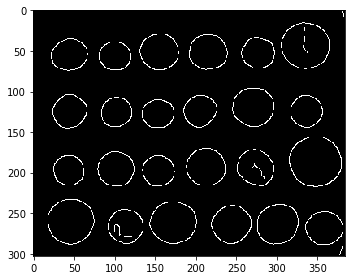

In [3]:
edges = canny(img_coins/255., sigma=3)
imshow(edges)

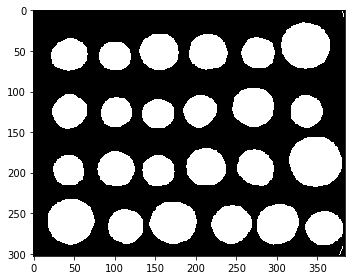

In [4]:
fill_coins = ndi.binary_fill_holes(edges)
imshow(fill_coins)

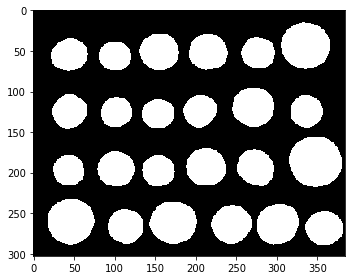

In [5]:
label_objects, nb_labels = ndi.label(fill_coins)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 15
mask_sizes[0] = 0
clean_coins = mask_sizes[label_objects]

imshow(clean_coins)

### Сегментация по регионам

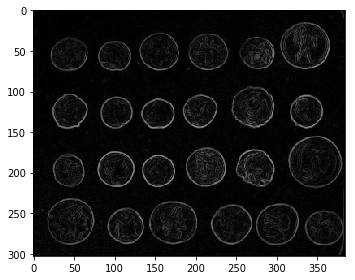

In [6]:
elevation_map = sobel(img_coins)
imshow(elevation_map)

In [7]:
markers = np.zeros_like(img_coins)
markers[img_coins < 30] = 1
markers[img_coins > 150] = 2

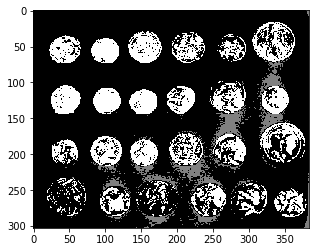

In [8]:
plt.imshow(markers, cmap=plt.cm.gray)

C:\Users\Marinka\Anaconda3\lib\site-packages\skimage\util\arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)


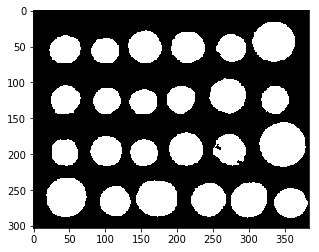

In [9]:
segmentation = watershed(elevation_map, markers)
plt.imshow(segmentation, cmap=plt.cm.gray)

In [10]:
segmentation = ndi.binary_fill_holes(segmentation - 1)

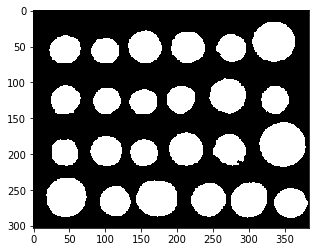

In [11]:
plt.imshow(segmentation, cmap=plt.cm.gray)

In [12]:
labeled_coins, _ = ndi.label(segmentation)

C:\Users\Marinka\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


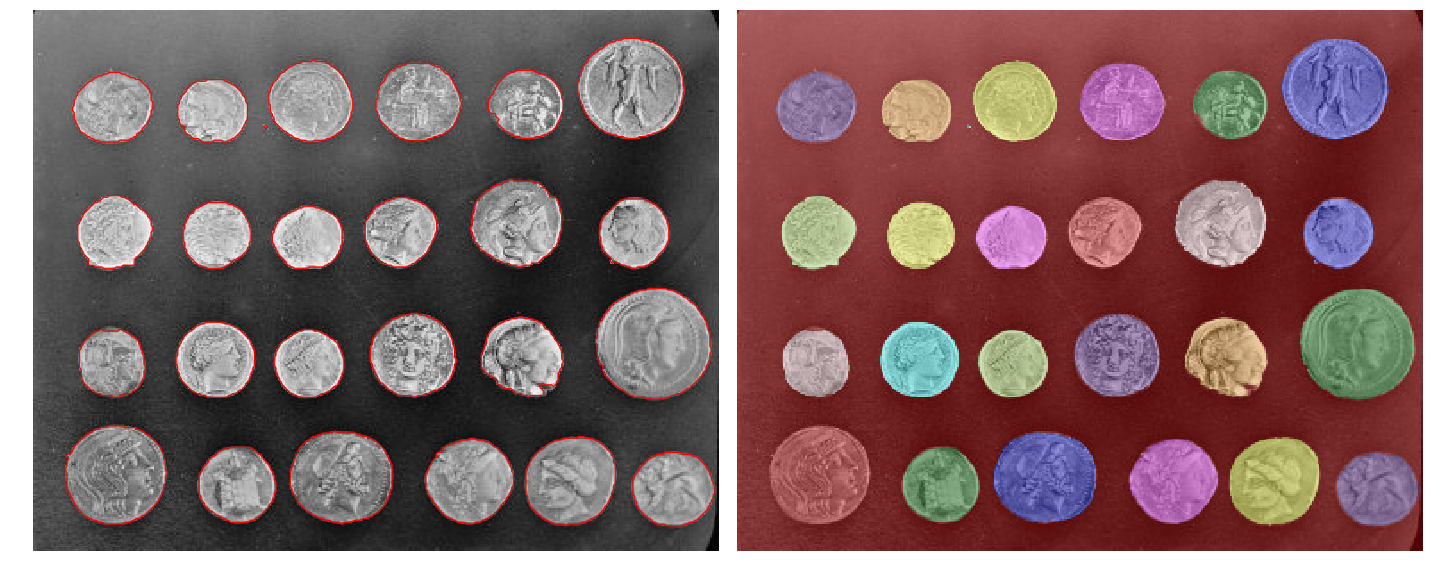

In [13]:
image_label_overlay = label2rgb(labeled_coins, image=img_coins)

fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
axes[0].imshow(img_coins, cmap=plt.cm.gray, interpolation='nearest')
axes[0].contour(segmentation, [0.5], linewidths=1.2, colors='r')
axes[1].imshow(image_label_overlay, interpolation='nearest')

for a in axes:
    a.axis('off')
    a.set_adjustable('box-forced')

plt.tight_layout()

### Сегментация текста

In [14]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

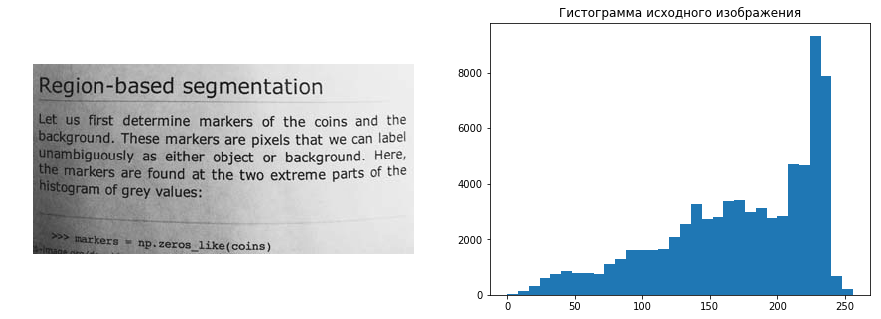

In [15]:
text = data.page()
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
axes[0].imshow(text, cmap = 'gray')
axes[0].axis('off')
axes[1].hist(text.ravel(), bins = 32, range = [0, 256])
axes[1].set_title('Гистограмма исходного изображения');

### Контролируемый порог

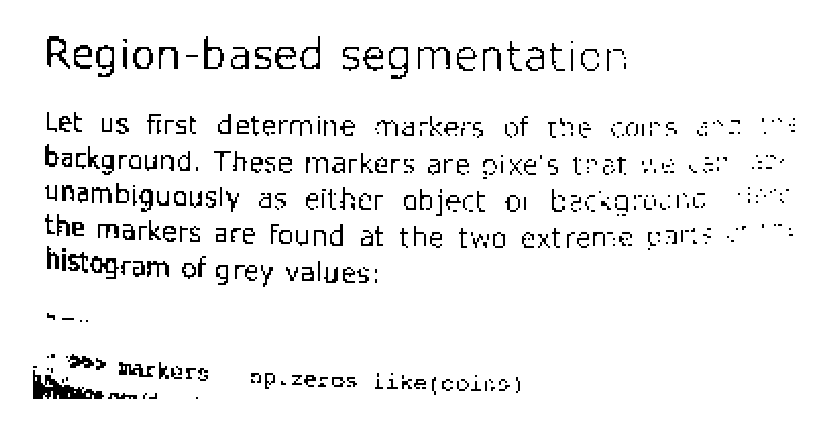

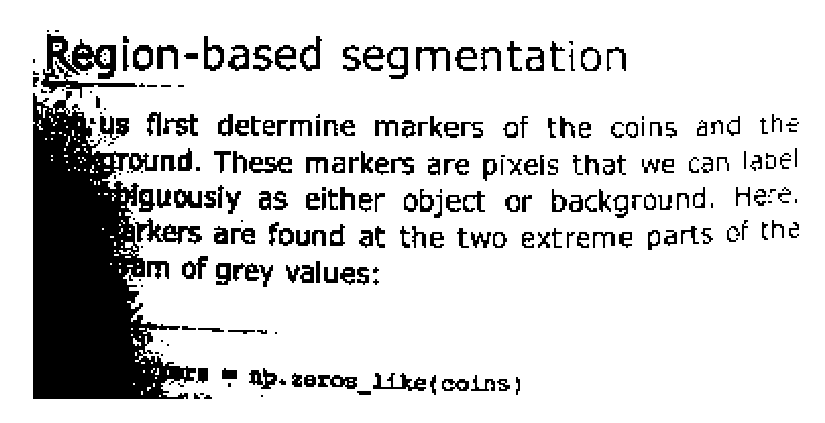

In [16]:
text_segmented_70 = text > 70
image_show(text_segmented_70);
text_segmented_120 = text > 120
image_show(text_segmented_120);

### Неконтролируемый порог

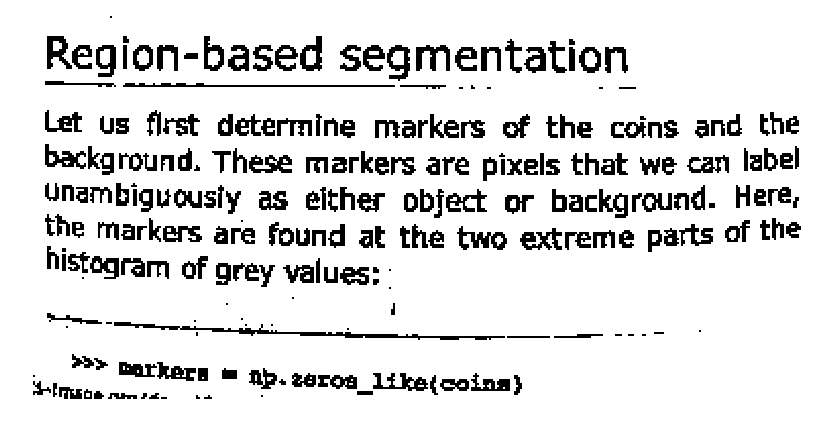

In [17]:
text_threshold = filters.threshold_local(text,block_size=51, offset=10) 
image_show(text > text_threshold);

## Сегментация лица

C:\Users\Marinka\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Marinka\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1eb5456e470>)

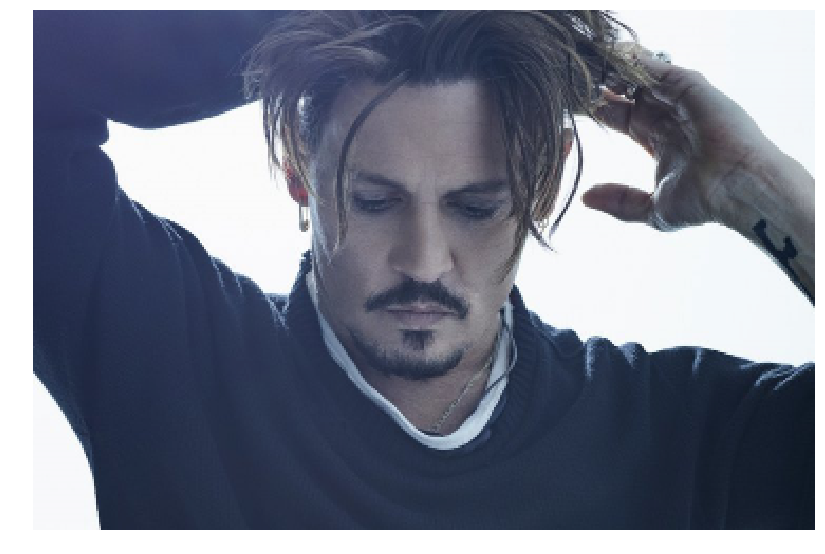

In [18]:
image = imread('jd.jpg') 
image = resize(image, (image.shape[0]//2,image.shape[1]//2))
image_show(image)

### Активная контурная сегментация

(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1eb550c84a8>)

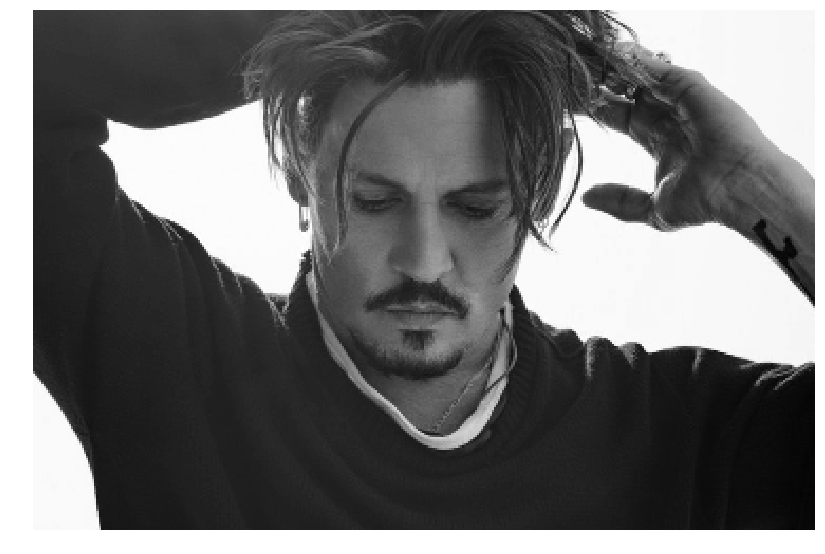

In [19]:
image_gray = color.rgb2gray(image) 
image_show(image_gray)

In [20]:
def circle_points(resolution, center, radius): 
     
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + radius*np.cos(radians)#polar co-ordinates
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T
    
points = circle_points(250, [100, 180], 80)[:-1]

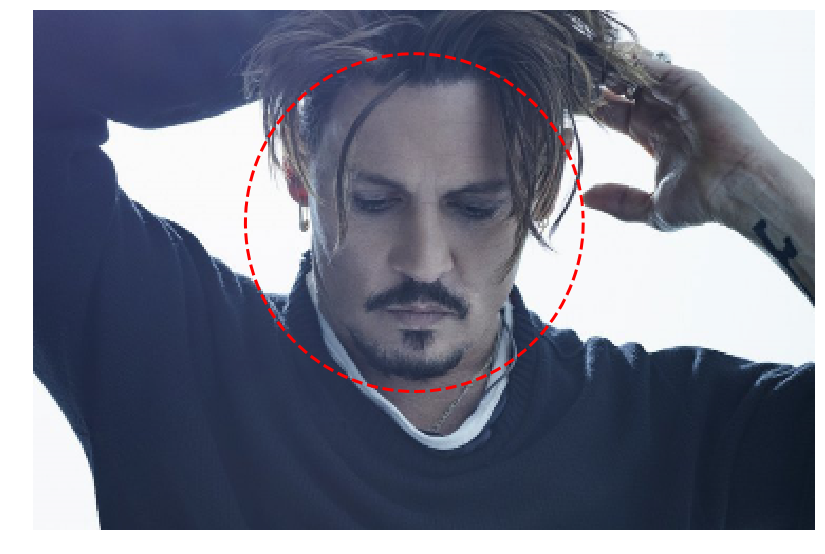

In [21]:
fig, ax = image_show(image)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)

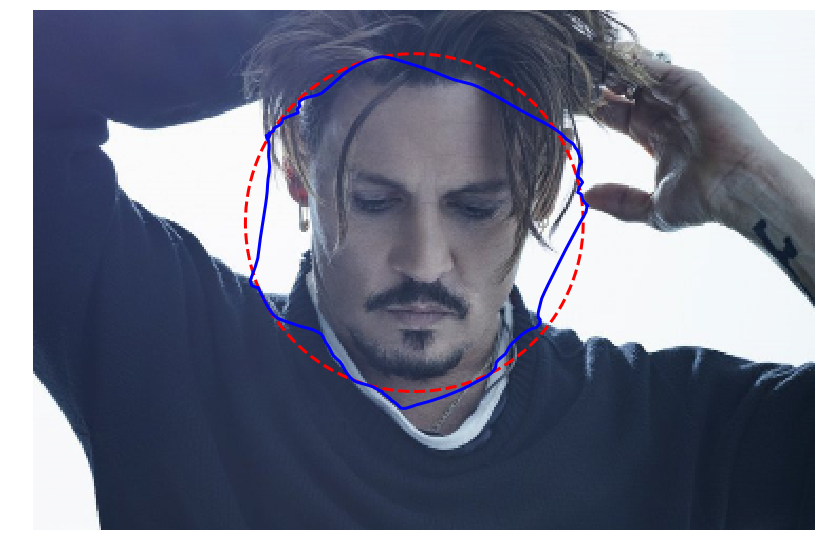

In [22]:
snake = seg.active_contour(image_gray, points,alpha=0.06,beta=0.3)
fig, ax = image_show(image)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

### Сегментация случайного прохождения

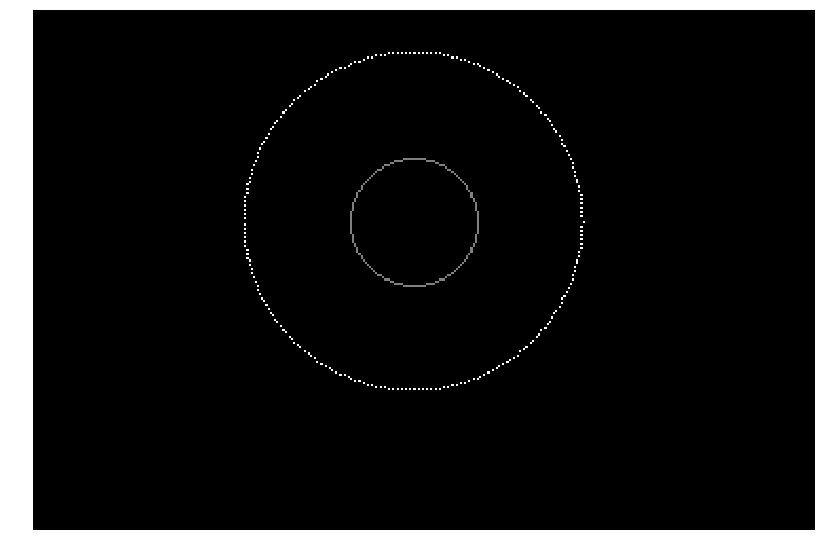

In [23]:
image_labels = np.zeros(image_gray.shape, dtype=np.uint8)
indices = draw.circle_perimeter(100, 180, 30)
image_labels[indices] = 1
image_labels[points[:, 1].astype(np.int), points[:, 0].astype(np.int)] = 2
image_show(image_labels);

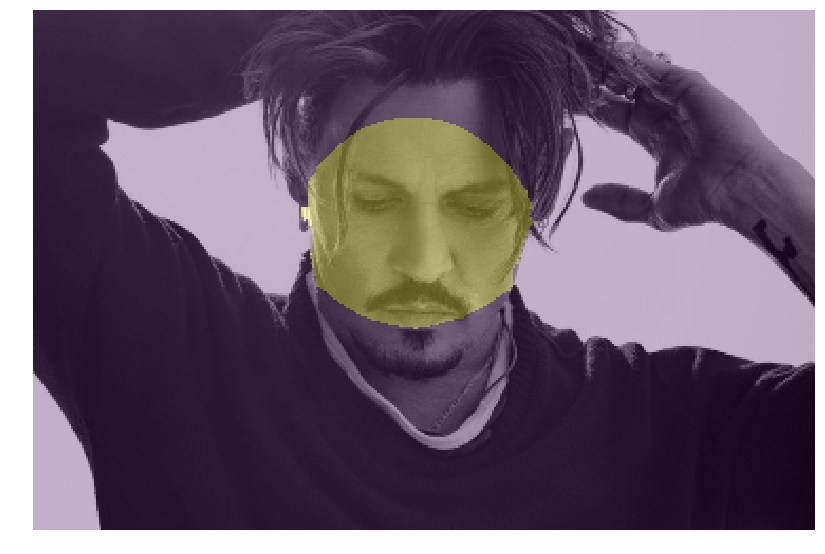

In [24]:
image_segmented = seg.random_walker(image_gray, image_labels)
# Check our results
fig, ax = image_show(image_gray)
ax.imshow(image_segmented == 1, alpha=0.3);

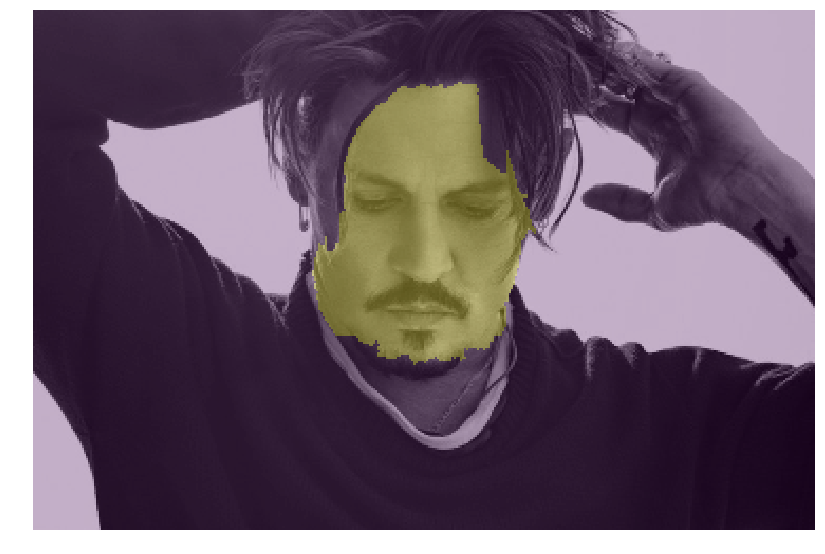

In [25]:
image_segmented = seg.random_walker(image_gray, image_labels, beta = 20000)

fig, ax = image_show(image_gray)
ax.imshow(image_segmented == 1, alpha=0.3);

### Простая Линейно-итеративная Кластеризация (SLIC)

In [26]:
image_slic = seg.slic(image,n_segments=155)

C:\Users\Marinka\Anaconda3\lib\site-packages\skimage\segmentation\slic_superpixels.py:156: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_z = grid_z[slices]
C:\Users\Marinka\Anaconda3\lib\site-packages\skimage\segmentation\slic_superpixels.py:157: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_y = grid_y[slices]
C:\Users\Marinka\Anaconda3\lib\site-packages\skimage\segmentation\slic_superpixels.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `ar

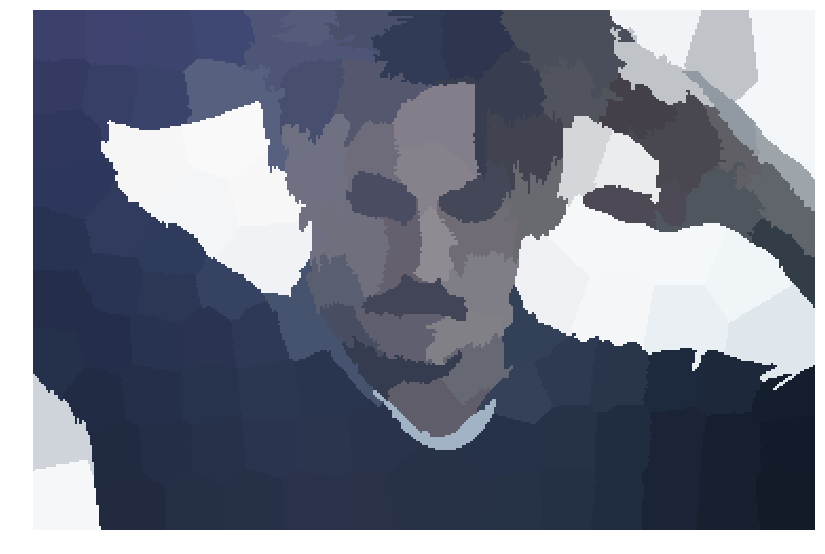

In [27]:
image_show(color.label2rgb(image_slic, image, kind='avg'));

### Felzenszwalb

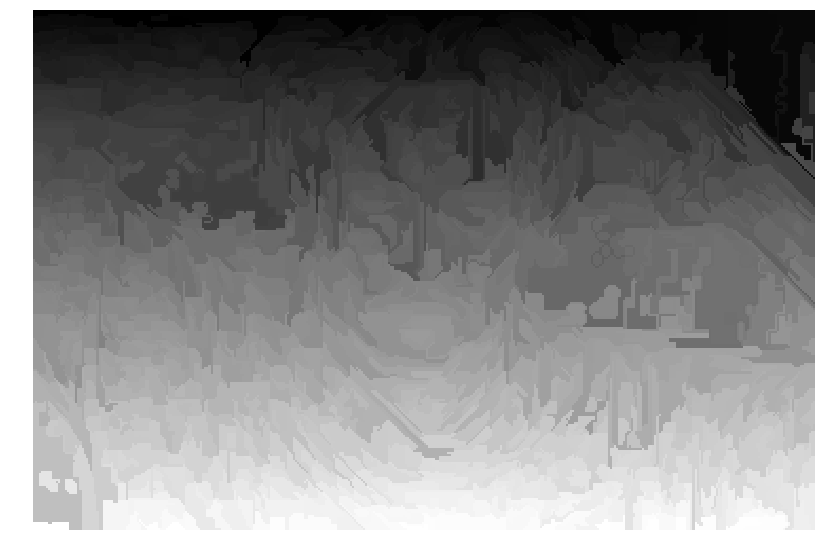

In [28]:
image_felzenszwalb = seg.felzenszwalb(image) 
image_show(image_felzenszwalb);

In [29]:
np.unique(image_felzenszwalb).size

1210

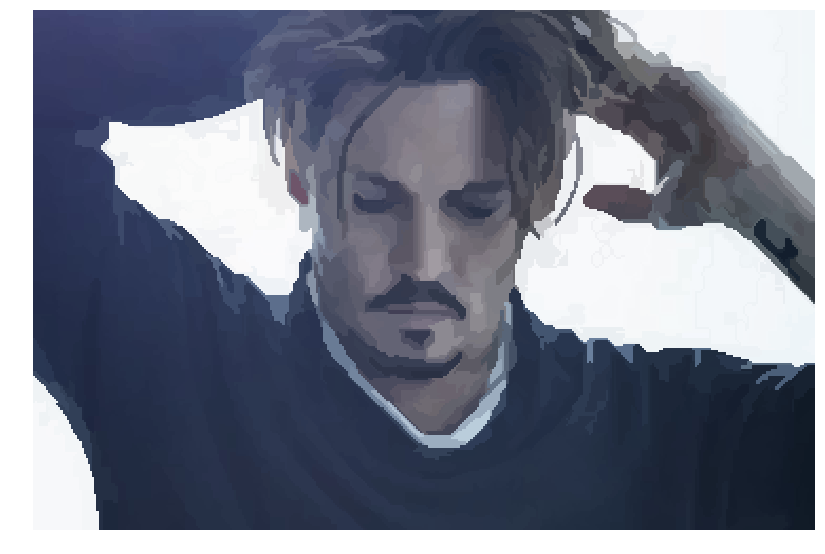

In [30]:
image_felzenszwalb_colored = color.label2rgb(image_felzenszwalb, image, kind='avg')
image_show(image_felzenszwalb_colored);

### OpenCV 

In [31]:
# загружаем изображение и отображаем его
image = cv2.imread("matrix-sunglasses.jpg")
cv2.imshow("Original image", image)

In [32]:
print(image.shape)# Изменяем размер изображения

(667, 1600, 3)


In [33]:
# Нам надо сохранить соотношение сторон,чтобы изображение не исказилось при уменьшении
# для этого считаем коэф. уменьшения стороны
final_wide = 200
r = float(final_wide) / image.shape[1]
dim = (final_wide, int(image.shape[0] * r))
 
# уменьшаем изображение до подготовленных размеров
resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
cv2.imshow("Resize image", resized)
cv2.waitKey(0)

-1

In [34]:
# вырежем участок изображения используя срезы
# мы же используем NumPy
cropped = image[30:130, 150:300]
cv2.imshow("Cropped image", cropped)
cv2.waitKey(0)

-1

In [35]:
# получим размеры изображения для поворота
# и вычислим центр изображения
(h, w) = image.shape[:2]
center = (w / 2, h / 2)
 
# повернем изображение на 180 градусов
M = cv2.getRotationMatrix2D(center, 180, 1.0)
rotated = cv2.warpAffine(image, M, (w, h))
cv2.imshow("Rotated image", rotated)
cv2.waitKey(0)

-1

In [36]:
#отразим изображение по горизонтали
flip_image = cv2.flip(image,1)
cv2.imshow("Flip image", flip_image)
cv2.waitKey(0)

-1

In [37]:
# запишем изображение на диск в формате png
cv2.imwrite("flip.png", flip_image)

True

## Поиск книг на изображениях

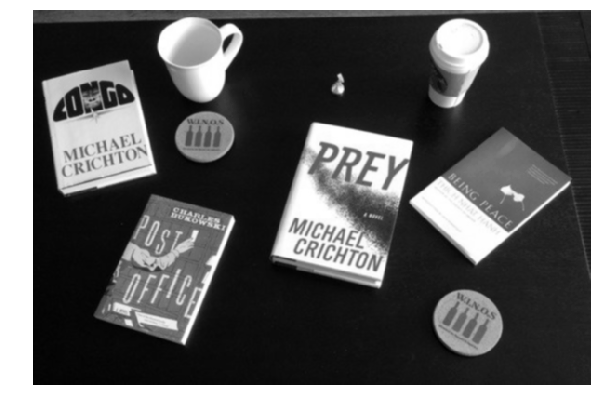

In [38]:
# загрузите изображение, смените цвет на оттенки серого и уменьшите резкость
image = cv2.imread("books.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (3, 3), 0)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(gray, cmap = plt.cm.gray)

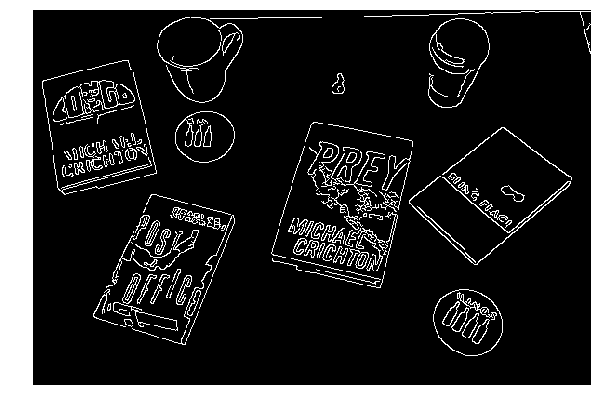

In [39]:
# распознавание контуров
edged = cv2.Canny(gray, 10, 250)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(edged, cmap = plt.cm.gray);

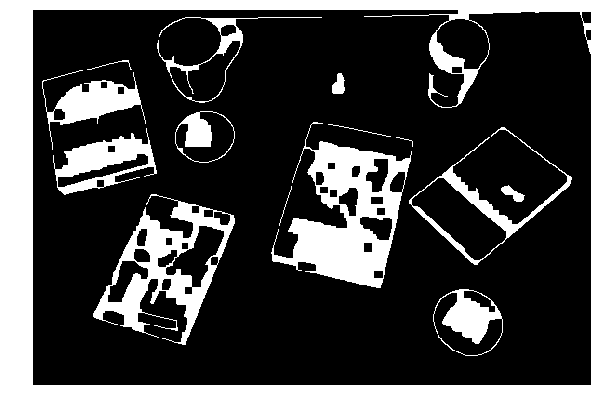

In [40]:
# создайте и примените закрытие
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(closed, cmap = plt.cm.gray);

In [41]:
# найдите контуры в изображении и подсчитайте количество книг
#cnts = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
cnts, hier = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
total = 0

# цикл по контурам
for c in cnts:
    # аппроксимируем (сглаживаем) контур
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # если у контура 4 вершины, предполагаем, что это книга
    if len(approx) == 4:
        cv2.drawContours(image, [approx], -1, (0, 255, 0), 4)
        total += 1

### Результат

Я нашёл 4 книг(и) на этой картинке


(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1eb54a94390>)

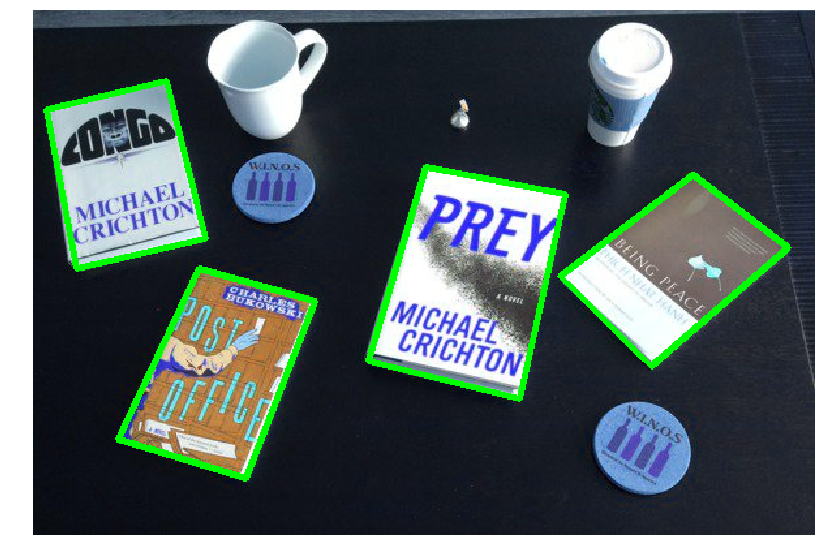

In [42]:
# показываем результирующее изображение
print("Я нашёл {0} книг(и) на этой картинке".format(total))
image_show(image)